In [2]:
import pyodbc
import pandas as pd
import numpy as np
from datetime import datetime

In [3]:
cnxn_str = ("Driver={SQL Server Native Client 11.0};"
            "Server=LAPTOP-CTTVUGH7;"
            "Database=tables_fait_1;"
            "Trusted_Connection=yes;")

cnxn = pyodbc.connect(cnxn_str)

In [4]:
cursor = cnxn.cursor()

In [5]:
import sqlalchemy
engine = sqlalchemy.create_engine("mssql+pyodbc://LAPTOP-CTTVUGH7/tables_fait_1?driver=SQL Server?Trusted_Connection=yes")
conn = engine.connect()

In [6]:
#improtation fait Sinistre
fait_Sinistre = pd.read_sql("SELECT * FROM [fait_sinistre]", cnxn)

In [7]:

#etatVehicule is almost null
#"date ajout" we already have "data dinsertion"
#"énumeroDuSinistreé" inutile ona a sinistre ID
#"typeImmatriculationVehiculeAdverse" we have "numeroImmatriculationVehiculeAdverse ""
#"numPolice" we "id police"

fait_Sinistre = fait_Sinistre.drop(['index','identificationTiers',
                                    'numeroDePoliceCompagnieAdverse','typeImmatriculationVehiculeAdverse'
                                   ,'dateAjout','numPolice'], axis=1)

In [8]:
fait_Sinistre = fait_Sinistre.drop(['numeroImmatriculationVehiculeAdverse','codeAgence'],axis=1)

1)abnormal number of accidents

In [9]:
condition = fait_Sinistre.groupby('CodeAssure_id').CodeAssure_id.transform('size') >=15

In [10]:

fait_Sinistre.loc[condition, 'Fraud'] = 1

In [11]:
#test des changements
fait_Sinistre['Fraud'].value_counts()

0    517797
1     45005
Name: Fraud, dtype: int64

2) Detection de fraud selon nombre de clients qui ont type de police individuelle et ont plusieurs voitures (min 4)

In [12]:
query = "SELECT count(CodeVehicule_id) as count_CodeVehicule_id,CodeAssure_id FROM fait_Sinistre  where typePolice='I' group by CodeAssure_id having count(CodeVehicule_id)>3 "
results = cursor.execute(query).fetchall()

In [13]:
dataframe = pd.read_sql(query, con = conn)
dataframe

,count_CodeVehicule_id,CodeAssure_id
0,5,396558.0
1,4,56927.0
2,9,275767.0
3,5,105025.0
4,19,1558480.0
...,...,...
5867,6,1563996.0
5868,4,1057722.0
5869,8,972929.0
5870,7,248932.0


In [14]:
condition=(fait_Sinistre["CodeAssure_id"].isin(dataframe["CodeAssure_id"]))
fait_Sinistre.loc[condition,'Fraud']=1

2) planned accidents

In [15]:

query = """SELECT count (numeroImmatriculationVehiculeAdverse) as count, CodeVehicule_id 
        from fait_sinistre group by CodeVehicule_id having count (numeroImmatriculationVehiculeAdverse) >3"""
results = cursor.execute(query).fetchall()

In [16]:
dataframe = pd.read_sql(query, con = conn)
dataframe

,count,CodeVehicule_id
0,6,1221580.0
1,4,53020.0
2,4,243191.0
3,4,847221.0
4,6,528686.0
...,...,...
1838,5,372301.0
1839,4,863147.0
1840,4,344568.0
1841,5,1394637.0


In [17]:
condition=(fait_Sinistre["CodeVehicule_id"].isin(dataframe["CodeVehicule_id"]))
fait_Sinistre.loc[condition,'Fraud']=2

///Remplissage des valeurs manquantes:

1)Type Police  (ajoutee I si le nombre de vehicule est inferieure a 4 sinon le type est F)

In [18]:
query = """"SELECT count(CodeVehicule_id) as count_CodeVehicule_id,CodeAssure_id 
        FROM fait_Sinistre  where typePolice is NULL 
        group by CodeAssure_id having count(CodeVehicule_id)<4 """
results = cursor.execute(query).fetchall()

In [19]:
dataframe = pd.read_sql(query, con = conn)
dataframe

,count_CodeVehicule_id,CodeAssure_id
0,1,284449.0
1,1,1214865.0
2,1,1375267.0
3,1,882004.0
4,2,1346901.0
...,...,...
195612,1,1189094.0
195613,2,70373.0
195614,1,1096233.0
195615,1,1253262.0


In [20]:
condition=(fait_Sinistre["CodeAssure_id"].isin(dataframe["CodeAssure_id"]))
fait_Sinistre.loc[condition,'typePolice']='I'

In [21]:
fait_Sinistre['typePolice'].isnull().sum()

83749

In [22]:
query =""" "SELECT count(CodeVehicule_id) as count_CodeVehicule_id,CodeAssure_id
        FROM fait_Sinistre  where typePolice is NULL
        group by CodeAssure_id having count(CodeVehicule_id)>=4 """"
results = cursor.execute(query).fetchall()

In [23]:
dataframe = pd.read_sql(query, con = conn)
dataframe

,count_CodeVehicule_id,CodeAssure_id
0,4,583802.0
1,4,51749.0
2,4,1271948.0
3,4,579552.0
4,5,1094979.0
...,...,...
10312,11,1079099.0
10313,4,1345261.0
10314,5,636744.0
10315,8,1267330.0


In [24]:
condition=(fait_Sinistre["CodeAssure_id"].isin(dataframe["CodeAssure_id"]))
fait_Sinistre.loc[condition,'typePolice']='F'

In [25]:
fait_Sinistre['typePolice'].isnull().sum()

0

2) Lieu du sinistre

In [26]:
fait_Sinistre['lieuDuSinistre']=fait_Sinistre['lieuDuSinistre'].str.upper()
fait_Sinistre['lieuDuSinistre']=fait_Sinistre['lieuDuSinistre'].fillna("unkown")

3 ) dateOuvertureDuSinistre

In [27]:
fait_Sinistre['dateOuvertureDuSinistre'].value_counts().sum()

562802

In [28]:
fait_Sinistre['dateOuvertureDuSinistre']= fait_Sinistre['dateOuvertureDuSinistre'].astype('datetime64[ns]')

6) Code compagnie (les valeurs les plus utulises sont 1 12 et 9 donc on va remplir les donnees avec ces variables)

In [29]:
fait_Sinistre['codeCompagnie'].value_counts()

1.0     60861
12.0    37337
9.0     37055
2.0     24171
6.0     19278
7.0     14785
4.0      8228
15.0     5908
5.0      4238
8.0      4197
3.0      1784
14.0     1270
11.0      753
10.0      148
13.0       30
Name: codeCompagnie, dtype: int64

In [30]:
fill=[1,12,9]
x = np.array([[1],[12],[9]])
x=np.repeat(x, 114253)
fait_Sinistre.loc[fait_Sinistre["codeCompagnie"].isnull(), "codeCompagnie"] = x
fait_Sinistre["codeCompagnie"] = fait_Sinistre["codeCompagnie"].astype("int64") 
fait_Sinistre["codeCompagnie"].dtype

dtype('int64')

In [31]:
fait_Sinistre["codeCompagnieAdverse"]=fait_Sinistre["codeCompagnieAdverse"].fillna(1, limit=100000)
fait_Sinistre["codeCompagnieAdverse"]=fait_Sinistre["codeCompagnieAdverse"].fillna(14, limit=100000)
fait_Sinistre["codeCompagnieAdverse"]=fait_Sinistre["codeCompagnieAdverse"].fillna(11, limit=60000)
fait_Sinistre["codeCompagnieAdverse"]=fait_Sinistre["codeCompagnieAdverse"].fillna(6)
fait_Sinistre["codeCompagnieAdverse"].value_counts()

1.0     150221
14.0    148783
11.0     86438
6.0      58460
9.0      17576
2.0      14692
12.0     14323
0.0      12803
10.0     12399
7.0       9702
5.0       8689
4.0       5835
15.0      5306
13.0      5012
8.0       4127
99.0      3592
3.0       3547
16.0       483
18.0       389
20.0       244
19.0       170
17.0        11
Name: codeCompagnieAdverse, dtype: int64

In [32]:
fait_Sinistre["codeCompagnieAdverse"] = fait_Sinistre["codeCompagnieAdverse"].astype("int64") 
fait_Sinistre["codeCompagnieAdverse"].dtype

dtype('int64')

7)Pourcentage compagnie adverse

In [33]:
fait_Sinistre["porcentageCompagnieAdverse"]=fait_Sinistre["porcentageCompagnieAdverse"].fillna(0)
fait_Sinistre["porcentageCompagnieAdverse"] = fait_Sinistre["porcentageCompagnieAdverse"].astype("int64") 
fait_Sinistre["porcentageCompagnieAdverse"].dtype

dtype('int64')

8)Etat police

In [34]:
fait_Sinistre["Etat_Police"].value_counts()

V    203275
R     16317
S       451
Name: Etat_Police, dtype: int64

In [35]:
fait_Sinistre["Etat_Police"].isnull().sum()

342759

In [36]:
fait_Sinistre["Etat_Police"]=fait_Sinistre["Etat_Police"].fillna("V",limit=290000)

In [37]:
fait_Sinistre["Etat_Police"].isnull().sum()

52759

In [38]:
fait_Sinistre["Etat_Police"]=fait_Sinistre["Etat_Police"].fillna("R",limit=52000)

In [39]:
fait_Sinistre["Etat_Police"]=fait_Sinistre["Etat_Police"].fillna("S")

In [40]:
fait_Sinistre["Etat_Police"].isnull().sum()

0

9)Nature police

In [41]:
fait_Sinistre["naturePolice"].isnull().sum()

342759

In [42]:
fait_Sinistre["naturePolice"].value_counts()

R    214446
T      5597
Name: naturePolice, dtype: int64

In [43]:
fait_Sinistre["naturePolice"]=fait_Sinistre["naturePolice"].fillna("T",limit=9000)


In [44]:
fait_Sinistre["naturePolice"]=fait_Sinistre["naturePolice"].fillna("R")


10)Type intermediaire

In [45]:
fait_Sinistre["typeIntermediaire"].value_counts()

1.0    161858
2.0     39483
3.0     18702
Name: typeIntermediaire, dtype: int64

In [46]:
fait_Sinistre["typeIntermediaire"].isnull().sum()

342759

C:\Users\Rayen\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

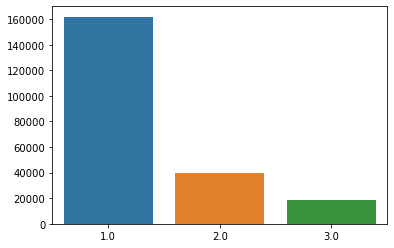

In [47]:
import seaborn as sns
y = fait_Sinistre["typeIntermediaire"].value_counts()
sns.barplot(y.index, y.values)

In [48]:
fait_Sinistre["typeIntermediaire"]=fait_Sinistre["typeIntermediaire"].fillna(1,limit=250000)

In [49]:
fait_Sinistre["typeIntermediaire"]=fait_Sinistre["typeIntermediaire"].fillna(2,limit=65000)

In [50]:
fait_Sinistre["typeIntermediaire"]=fait_Sinistre["typeIntermediaire"].fillna(3)

In [51]:
fait_Sinistre["typeIntermediaire"].value_counts()

1.0    411858
2.0    104483
3.0     46461
Name: typeIntermediaire, dtype: int64

In [52]:
fait_Sinistre["typeIntermediaire"] = fait_Sinistre["typeIntermediaire"].astype("int64") 
fait_Sinistre["typeIntermediaire"].dtype

dtype('int64')

11)Type immatriculation

In [53]:
fait_Sinistre["typeImmatriculation"].value_counts()

TU      426152
RS        9872
REM        764
ES         728
TRAC       518
MD         145
CD         108
PAT         37
-           11
CMD          7
CC           2
Name: typeImmatriculation, dtype: int64

In [54]:
fait_Sinistre["typeImmatriculation"]=fait_Sinistre["typeImmatriculation"].fillna('TU')

In [55]:
fait_Sinistre["typeImmatriculation"].value_counts()

TU      550610
RS        9872
REM        764
ES         728
TRAC       518
MD         145
CD         108
PAT         37
-           11
CMD          7
CC           2
Name: typeImmatriculation, dtype: int64

12)Mouvement Du sinistre

In [56]:
fait_Sinistre["mouvementDusinistre"].isnull().sum()

22353

In [57]:
fait_Sinistre["mouvementDusinistre"].value_counts()

3.0    418372
2.0    103655
1.0     18422
Name: mouvementDusinistre, dtype: int64

In [58]:
fait_Sinistre["mouvementDusinistre"]=fait_Sinistre["mouvementDusinistre"].fillna('3')

In [59]:
fait_Sinistre["mouvementDusinistre"] = fait_Sinistre["mouvementDusinistre"].astype("int64") 
fait_Sinistre["mouvementDusinistre"].dtype

dtype('int64')

In [60]:
import sqlalchemy
engine = sqlalchemy.create_engine("mssql+pyodbc://LAPTOP-CTTVUGH7/tables_fait_1?driver=SQL Server?Trusted_Connection=yes")
conn = engine.connect()

In [61]:
fait_Sinistre.to_sql('fait_Sinistre_fraud', conn, if_exists='replace')